In [3]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from scellst.constant import METRICS_DIR
from scellst.utils import split_to_dict
from scellst.metrics.metric_utils import format_metric_df

from sCellST_reproducibility.reproducibility_notebooks.utils_plot import plot_metrics_simulation
from sCellST_reproducibility.reproducibility_notebooks.utils_analyses import select_best_lr_model

%load_ext autoreload
%autoreload 2

In [2]:
# Params plot
plt.rcParams.update({"font.size": 14})
pd.options.display.float_format = '{:,.4f}'.format

In [3]:
SAVE_DIR_TAG = "simulation"

LIST_MODEL_TYPE = ["mil", "supervised"]

SAVE_PATH = Path("figures/simulations")
SAVE_PATH.mkdir(exist_ok=True)

In [4]:
# Prepare paths
all_metrics_paths = []
for model_type in LIST_MODEL_TYPE:
    # Prepare paths
    metrics_dir = METRICS_DIR / SAVE_DIR_TAG / model_type
    metrics_paths = list(metrics_dir.iterdir())
    print(f"Found {len(metrics_paths)} paths for model: {model_type}")
    all_metrics_paths.extend(metrics_paths)

Found 144 paths for model: mil
Found 152 paths for model: supervised


In [5]:
# Load metrics
all_df = []
for path in tqdm(all_metrics_paths):
    df = pd.read_csv(path, index_col=0)
    df = df.fillna(0.)
    all_df.append(df)

# Concatenate all metrics
metrics = pd.concat(all_df).reset_index(drop=True)
metrics["tag"] = [path.stem for path in all_metrics_paths]

  0%|          | 0/296 [00:00<?, ?it/s]

In [6]:
# Format metrics for plotting
metrics = format_metric_df(metrics)
df_hp = pd.DataFrame(metrics["tag"].apply(split_to_dict).to_list())
metrics = pd.concat([metrics, df_hp], axis=1)

list_hp = df_hp.columns.sort_values(ascending=True).tolist()
list_hp.remove("train_slide")
print(f"Found {list_hp} parameters.")

Found ['dataset_handler', 'embedding_tag', 'genes', 'infer_mode', 'lr', 'scale', 'task_type', 'test_slide'] parameters.


In [7]:
dict_rename = {
    "embedding_tag": {
        "moco-TENX65-rn50": "SSL embedding",
        "one-hot-celltype": "one hot encoded cell type"
    },
    "test_slide": {
        "TENX65_sim_cell_test": "cell",
        "TENX65_sim_centroid_test": "centroid",
        "TENX65_sim_random_test": "random",
    },
    "genes": {
        "1000_hvg_sim": "HVG",
        "marker_sim": "MG",
    },
    "task_type": {
        "nb_mean_regression": "NB (mean parametrisation)",
        "nb_total_regression": "NB (total counts parametrisation)",
    }
}
metrics = metrics.replace(dict_rename)
col_rename = {
    "dataset_handler": "learning framework",
    "test_slide": "scenario"
}
metrics = metrics.rename(columns=col_rename)
metrics = metrics.rename(columns=lambda name: name.replace('_', ' '))

In [8]:
metrics["lr"] = metrics["lr"].astype(float)
metrics["category"] = metrics["infer mode"] + " " + metrics["genes"]

# 1. Plots

Plot: Comparison of different scenarios
infer mode  scenario
bag         cell        1000
            centroid    1000
            random      1000
instance    cell        1000
            centroid    1000
            random      1000
dtype: int64
infer mode  scenario
bag         cell        0.2039
            centroid    0.9343
            random     -0.0017
instance    cell        0.2279
            centroid    0.9276
            random      0.0012
Name: pcc, dtype: float64


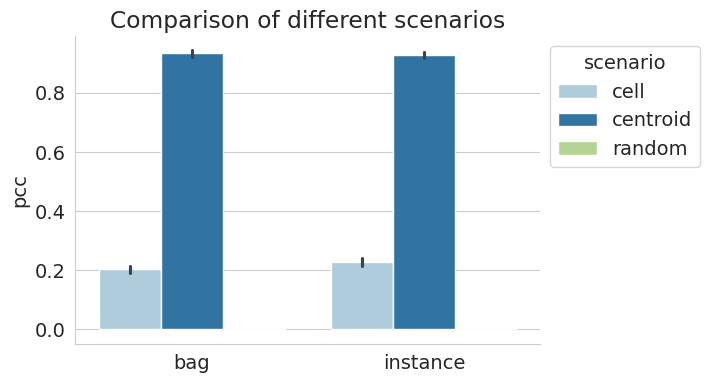

Plot: Comparison of different scenarios
infer mode  scenario
bag         cell        1000
            centroid    1000
            random      1000
instance    cell        1000
            centroid    1000
            random      1000
dtype: int64
infer mode  scenario
bag         cell        0.2122
            centroid    0.9495
            random     -0.0016
instance    cell        0.1763
            centroid    0.6896
            random      0.0014
Name: scc, dtype: float64


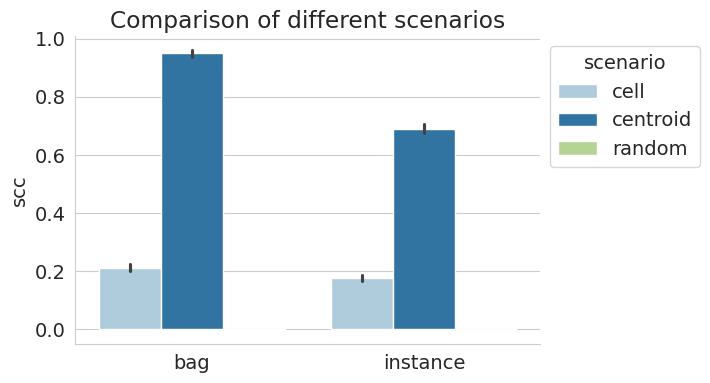

In [9]:
df_plot = metrics[
    (metrics["task type"] == "regression")
    & (metrics["embedding tag"] == "SSL embedding")
    & (metrics["genes"] == "HVG")
    & (metrics["lr"] == 0.0001)
    & (metrics["learning framework"] == "mil")
].copy()
for score in ["pcc", "scc"]:
    plot_metrics_simulation(
        df_plot,
        x="infer mode",
        y=score,
        save_path= SAVE_PATH / f"comparison_scenario_test_regression_{score}.png",
        title="Comparison of different scenarios",
        hue="scenario",
        # x_order=["spot level", "cell level"],
        # hue_order=["random", "centroid", "cell"],
    )

Plot: Comparison for different gene sets
 in the cell scenario at the cell level
infer mode  genes
bag         HVG      1000
            MG       1000
instance    HVG      1000
            MG       1000
dtype: int64
infer mode  genes
bag         HVG     0.2039
            MG      0.6811
instance    HVG     0.2279
            MG      0.7640
Name: pcc, dtype: float64


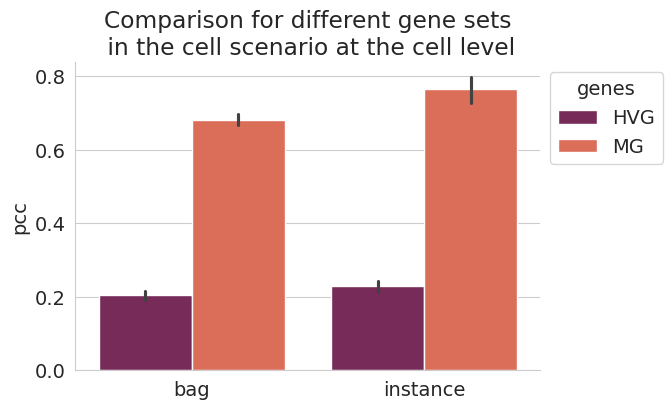

Plot: Comparison for different gene sets
 in the cell scenario at the cell level
infer mode  genes
bag         HVG      1000
            MG       1000
instance    HVG      1000
            MG       1000
dtype: int64
infer mode  genes
bag         HVG     0.2122
            MG      0.7528
instance    HVG     0.1763
            MG      0.5687
Name: scc, dtype: float64


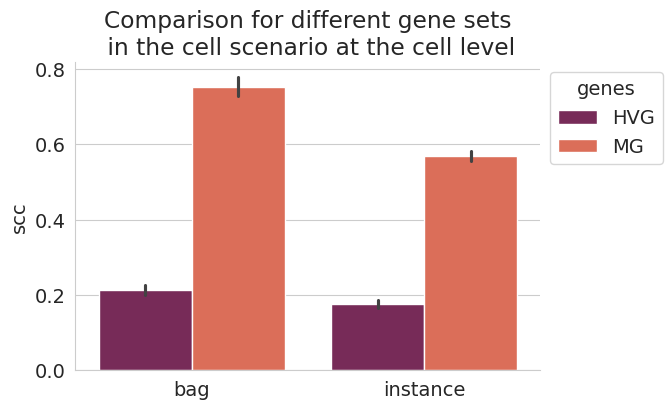

In [10]:
df_plot = metrics[
    (metrics["task type"] == "regression")
    & (metrics["embedding tag"] == "SSL embedding")
    & (metrics["lr"] == 0.0001)
    & (metrics["learning framework"] == "mil")
    & (metrics["scenario"] == "cell")
].copy()
for score in ["pcc", "scc"]:
    plot_metrics_simulation(
        df_plot,
        x="infer mode",
        y=score,
        hue="genes",
        save_path=SAVE_PATH / f"comparison_scenario_test_regression_{score}_genes.png",
        title="Comparison for different gene sets\n in the cell scenario at the cell level",
        # x_order=["spot level", "cell level"],
        # hue_order=["hvg", "marker"],
    )

Plot: Comparison of different frameworks
 in the cell scenario for marker genes
infer mode  task type                        
bag         NB (mean parametrisation)            1000
            NB (total counts parametrisation)    1000
            regression                           1000
instance    NB (mean parametrisation)            1000
            NB (total counts parametrisation)    1000
            regression                           1000
dtype: int64
infer mode  task type                        
bag         NB (mean parametrisation)           0.7313
            NB (total counts parametrisation)   0.7018
            regression                          0.6811
instance    NB (mean parametrisation)           0.7338
            NB (total counts parametrisation)   0.7036
            regression                          0.7640
Name: pcc, dtype: float64


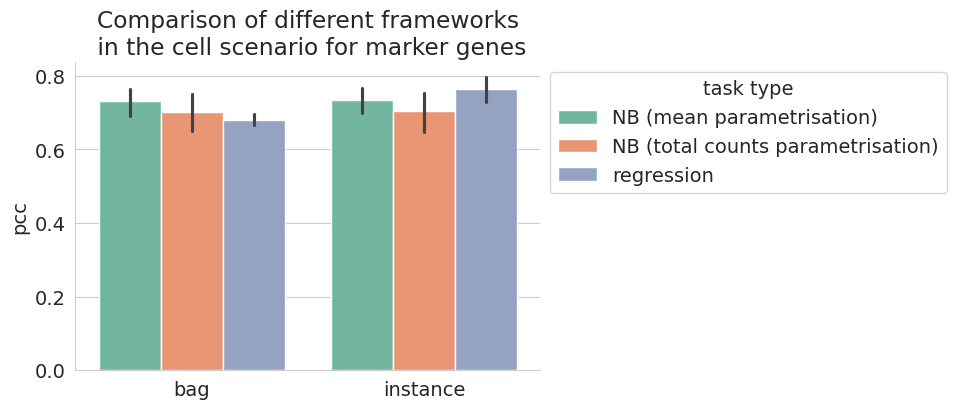

Plot: Comparison of different frameworks
 in the cell scenario for marker genes
infer mode  task type                        
bag         NB (mean parametrisation)            1000
            NB (total counts parametrisation)    1000
            regression                           1000
instance    NB (mean parametrisation)            1000
            NB (total counts parametrisation)    1000
            regression                           1000
dtype: int64
infer mode  task type                        
bag         NB (mean parametrisation)           0.7205
            NB (total counts parametrisation)   0.6482
            regression                          0.7528
instance    NB (mean parametrisation)           0.5650
            NB (total counts parametrisation)   0.4960
            regression                          0.5687
Name: scc, dtype: float64


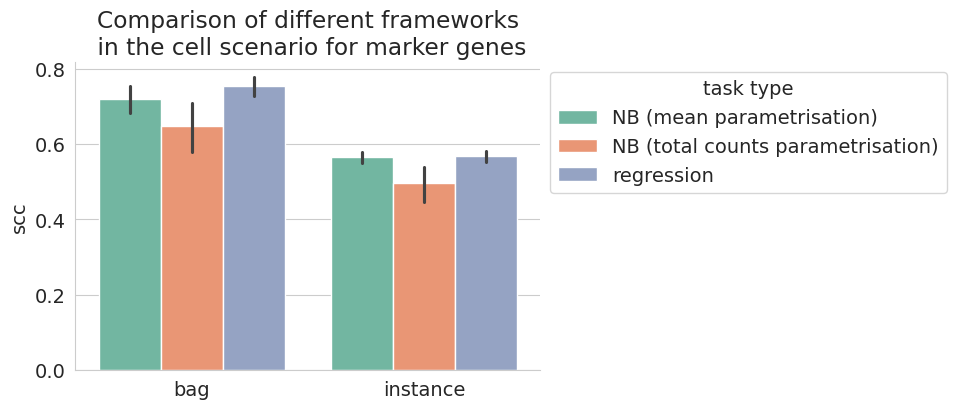

In [11]:
df_plot = metrics[
    (metrics["embedding tag"] == "SSL embedding")
    & (metrics["scenario"] == "cell")
    & (metrics["genes"] == "MG")
    & (metrics["learning framework"] == "mil")
].copy()
for score in ["pcc", "scc"]:
    df_plot_ = select_best_lr_model(
        df_plot, columns=["task type", "lr"], metric=score, gene_cat="MG"
    )
    plot_metrics_simulation(
        df_plot_,
        x="infer mode",
        y=score,
        save_path=SAVE_PATH / f"comparison_framework_test_cell_{score}.png",
        title="Comparison of different frameworks\n in the cell scenario for marker genes",
        hue="task type",
        # x_order=["spot level", "cell level"],
        # hue_order=["regression", "NB (mean parametrisation)", "NB (total count parametrisation)"],
    )

Plot: Comparison of different learning rates in cell scenario with regression
category      lr    
bag HVG       0.0000    1000
              0.0001    1000
              0.0010    1000
              0.0100    1000
bag MG        0.0000      51
              0.0001      51
              0.0010      51
              0.0100      51
instance HVG  0.0000    1000
              0.0001    1000
              0.0010    1000
              0.0100    1000
instance MG   0.0000      51
              0.0001      51
              0.0010      51
              0.0100      51
dtype: int64
category      lr    
bag HVG       0.0000   0.1986
              0.0001   0.2039
              0.0010   0.1442
              0.0100   0.1594
bag MG        0.0000   0.6633
              0.0001   0.6811
              0.0010   0.6669
              0.0100   0.6826
instance HVG  0.0000   0.2220
              0.0001   0.2279
              0.0010   0.1620
              0.0100   0.1789
instance MG   0.0000   0.7402
             

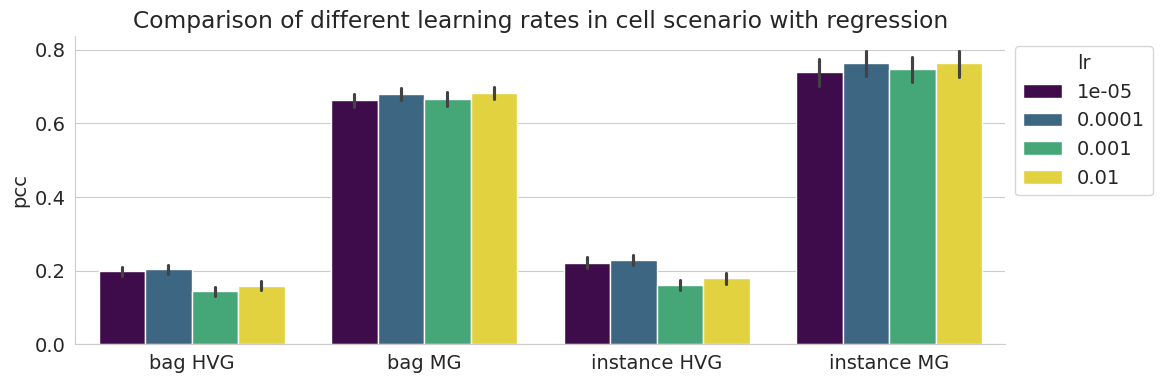

Plot: Comparison of different learning rates in cell scenario with regression
category      lr    
bag HVG       0.0000    1000
              0.0001    1000
              0.0010    1000
              0.0100    1000
bag MG        0.0000      51
              0.0001      51
              0.0010      51
              0.0100      51
instance HVG  0.0000    1000
              0.0001    1000
              0.0010    1000
              0.0100    1000
instance MG   0.0000      51
              0.0001      51
              0.0010      51
              0.0100      51
dtype: int64
category      lr    
bag HVG       0.0000   0.2060
              0.0001   0.2122
              0.0010   0.1532
              0.0100   0.1669
bag MG        0.0000   0.7338
              0.0001   0.7528
              0.0010   0.7369
              0.0100   0.7544
instance HVG  0.0000   0.1680
              0.0001   0.1763
              0.0010   0.1294
              0.0100   0.1289
instance MG   0.0000   0.5617
             

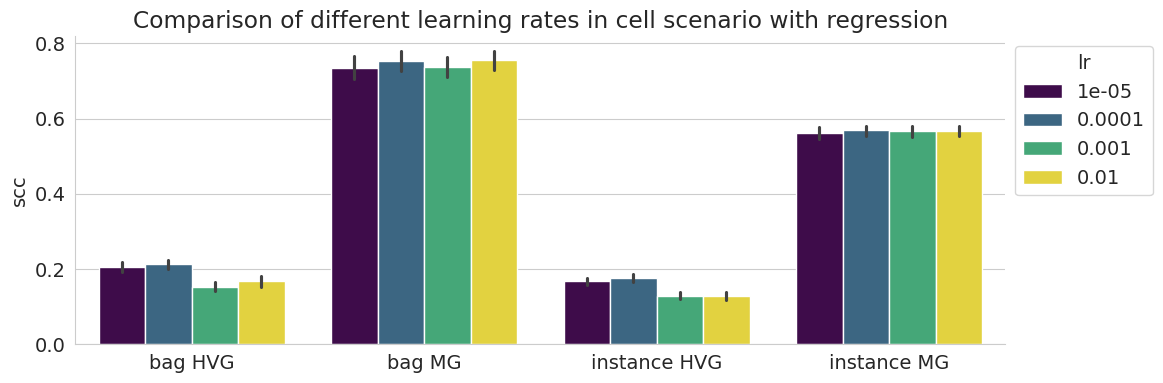

Plot: Comparison of different learning rates in cell scenario with NB (mean parametrisation)
category      lr    
bag HVG       0.0000    1000
              0.0001    1000
              0.0010    1000
              0.0100    1000
bag MG        0.0000      51
              0.0001      51
              0.0010      51
              0.0100      51
instance HVG  0.0000    1000
              0.0001    1000
              0.0010    1000
              0.0100    1000
instance MG   0.0000      51
              0.0001      51
              0.0010      51
              0.0100      51
dtype: int64
category      lr    
bag HVG       0.0000   0.1102
              0.0001   0.1828
              0.0010   0.1418
              0.0100   0.1617
bag MG        0.0000   0.5759
              0.0001   0.6786
              0.0010   0.6675
              0.0100   0.7313
instance HVG  0.0000   0.1100
              0.0001   0.1837
              0.0010   0.1423
              0.0100   0.1618
instance MG   0.0000   0.577

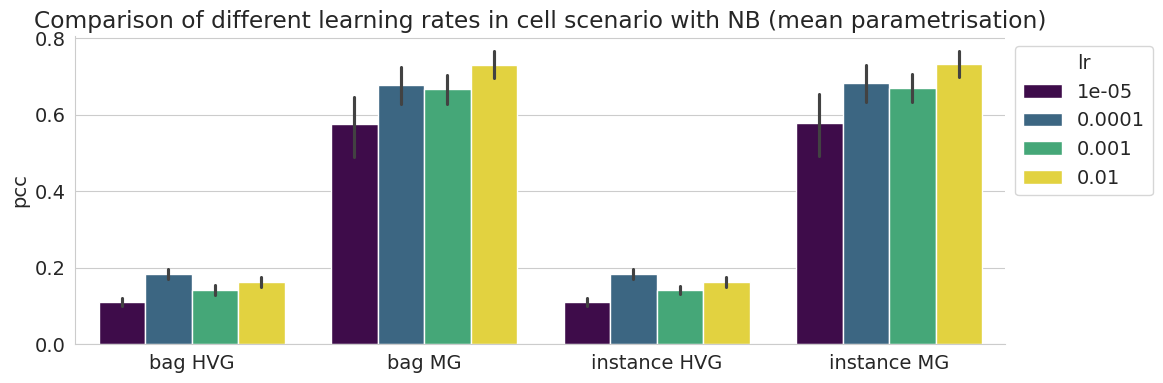

Plot: Comparison of different learning rates in cell scenario with NB (mean parametrisation)
category      lr    
bag HVG       0.0000    1000
              0.0001    1000
              0.0010    1000
              0.0100    1000
bag MG        0.0000      51
              0.0001      51
              0.0010      51
              0.0100      51
instance HVG  0.0000    1000
              0.0001    1000
              0.0010    1000
              0.0100    1000
instance MG   0.0000      51
              0.0001      51
              0.0010      51
              0.0100      51
dtype: int64
category      lr    
bag HVG       0.0000   0.1094
              0.0001   0.1810
              0.0010   0.1395
              0.0100   0.1594
bag MG        0.0000   0.5654
              0.0001   0.6676
              0.0010   0.6556
              0.0100   0.7205
instance HVG  0.0000   0.1066
              0.0001   0.1522
              0.0010   0.1117
              0.0100   0.1245
instance MG   0.0000   0.453

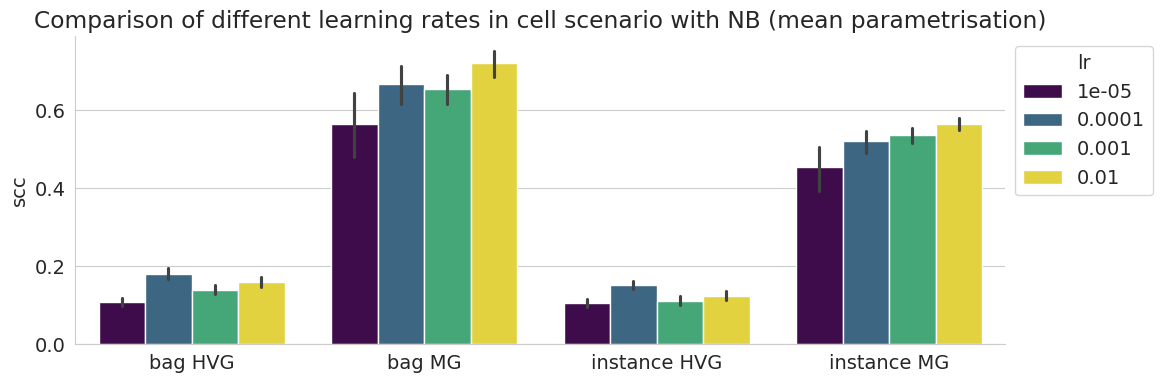

Plot: Comparison of different learning rates in cell scenario with NB (total counts parametrisation)
category      lr    
bag HVG       0.0000    1000
              0.0001    1000
              0.0010    1000
              0.0100    1000
bag MG        0.0000      51
              0.0001      51
              0.0010      51
              0.0100      51
instance HVG  0.0000    1000
              0.0001    1000
              0.0010    1000
              0.0100    1000
instance MG   0.0000      51
              0.0001      51
              0.0010      51
              0.0100      51
dtype: int64
category      lr    
bag HVG       0.0000   0.0460
              0.0001   0.1808
              0.0010   0.1716
              0.0100   0.1873
bag MG        0.0000   0.0037
              0.0001   0.4730
              0.0010   0.7018
              0.0100   0.6585
instance HVG  0.0000   0.0457
              0.0001   0.1808
              0.0010   0.1732
              0.0100   0.1878
instance MG   0.0000

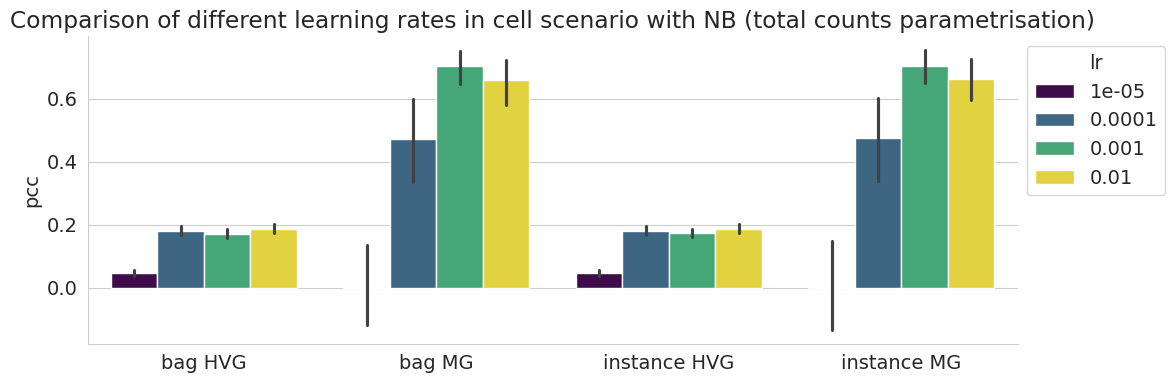

Plot: Comparison of different learning rates in cell scenario with NB (total counts parametrisation)
category      lr    
bag HVG       0.0000    1000
              0.0001    1000
              0.0010    1000
              0.0100    1000
bag MG        0.0000      51
              0.0001      51
              0.0010      51
              0.0100      51
instance HVG  0.0000    1000
              0.0001    1000
              0.0010    1000
              0.0100    1000
instance MG   0.0000      51
              0.0001      51
              0.0010      51
              0.0100      51
dtype: int64
category      lr    
bag HVG       0.0000   0.0477
              0.0001   0.1789
              0.0010   0.1694
              0.0100   0.1853
bag MG        0.0000   0.0006
              0.0001   0.4648
              0.0010   0.6910
              0.0100   0.6482
instance HVG  0.0000   0.0525
              0.0001   0.1475
              0.0010   0.1436
              0.0100   0.1537
instance MG   0.0000

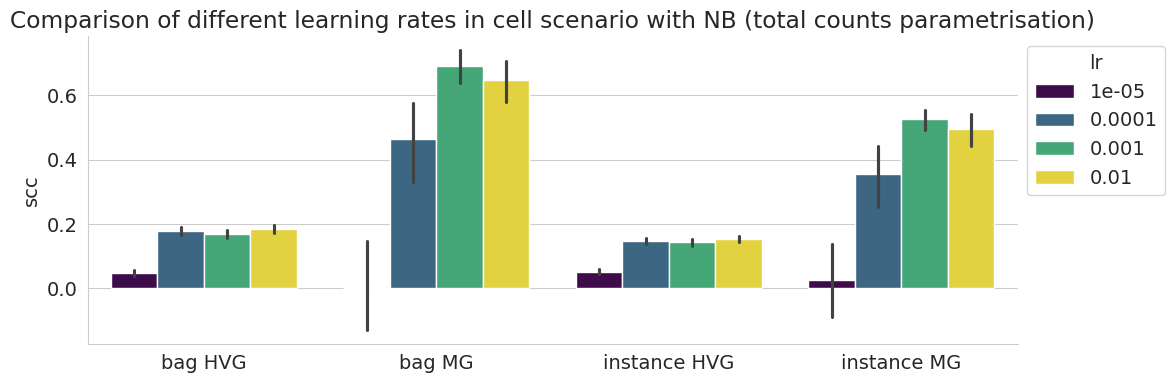

In [12]:
df_plot = metrics[
    (metrics["embedding tag"] == "SSL embedding")
    & (metrics["scenario"] == "cell")
    & (metrics["learning framework"] == "mil")
].copy()
for task_type in df_plot["task type"].drop_duplicates():
    for score in ["pcc", "scc"]:
        df_plot_ = df_plot[(df_plot["task type"] == task_type)].dropna()
        plot_metrics_simulation(
            df_plot_,
            x="category",
            y=score,
            title=f"Comparison of different learning rates in cell scenario with {task_type}",
            save_path=SAVE_PATH / f"comparison_lr_{task_type}_test_cell_{score}.png",
            hue="lr",
            # x_order=[
            #     "spot level hvg",
            #     "spot level marker",
            #     "cell level hvg",
            #     "cell level marker",
            # ],
        )

Plot: Comparison of different input types
in cell scenario at the cell level
genes  embedding tag            
HVG    SSL embedding                1000
       one hot encoded cell type    1000
MG     SSL embedding                1000
       one hot encoded cell type    1000
dtype: int64
genes  embedding tag            
HVG    SSL embedding               0.2279
       one hot encoded cell type   0.2471
MG     SSL embedding               0.7640
       one hot encoded cell type   0.7835
Name: pcc, dtype: float64


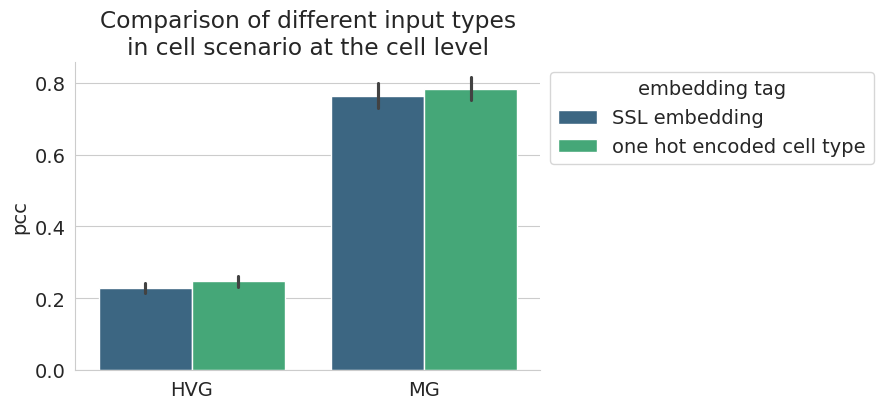

Plot: Comparison of different input types
in cell scenario at the cell level
genes  embedding tag            
HVG    SSL embedding                1000
       one hot encoded cell type    1000
MG     SSL embedding                1000
       one hot encoded cell type    1000
dtype: int64
genes  embedding tag            
HVG    SSL embedding               0.1763
       one hot encoded cell type   0.1848
MG     SSL embedding               0.5687
       one hot encoded cell type   0.5841
Name: scc, dtype: float64


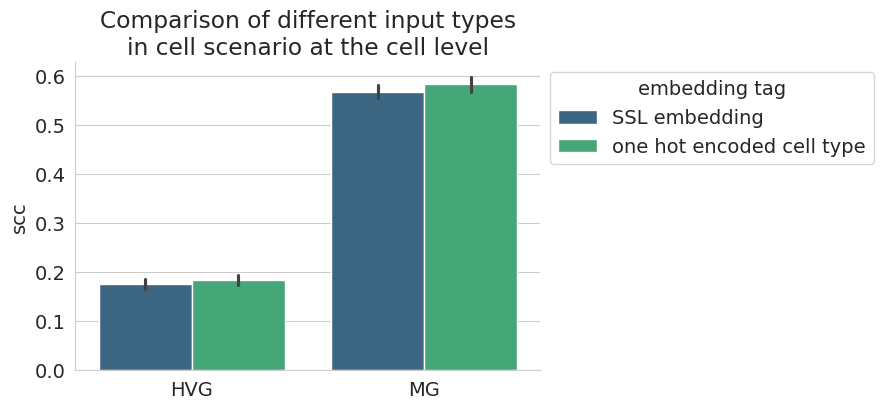

In [13]:
df_plot = metrics[
    (metrics["scenario"] == "cell")
    & (metrics["learning framework"] == "mil")
    & (metrics["lr"] == 0.0001)
    & (metrics["infer mode"] == "instance")
    & (metrics["task type"] == "regression")
].copy()
for score in ["pcc", "scc"]:
    plot_metrics_simulation(
        df_plot,
        x="genes",
        y=score,
        title="Comparison of different input types\nin cell scenario at the cell level",
        save_path= SAVE_PATH / f"comparison_input_type_test_cell_{score}.png",
        hue="embedding tag",
        # x_order=["hvg", "marker"],
    )

In [14]:
df_plot = metrics[
    (metrics["scenario"] == "cell")
    & (metrics["task type"] == "regression")
    & (metrics["embedding tag"] == "SSL embedding")
    & (metrics["infer mode"] == "instance")
    & (metrics["scale"] != "slide_scaling")
].copy()

Plot: Comparison of different learning frameworks
 at the cell level
genes  learning framework
HVG    mil                   1000
       supervised            1000
MG     mil                   1000
       supervised            1000
dtype: int64
genes  learning framework
HVG    mil                  0.2279
       supervised           0.2030
MG     mil                  0.7640
       supervised           0.7820
Name: pcc, dtype: float64


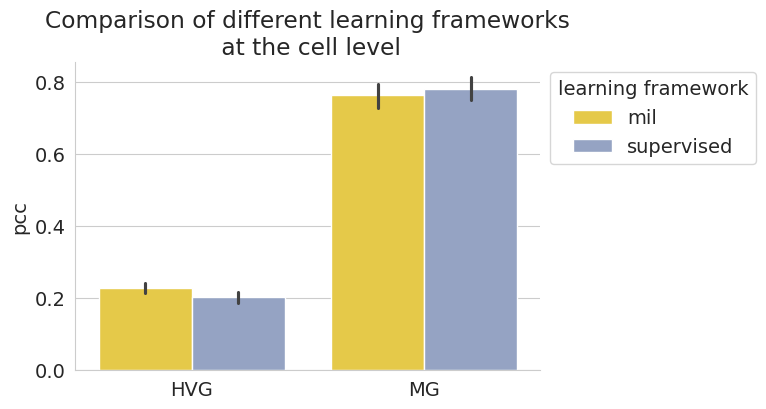

Plot: Comparison of different learning frameworks
 at the cell level
genes  learning framework
HVG    mil                   1000
       supervised            1000
MG     mil                   1000
       supervised            1000
dtype: int64
genes  learning framework
HVG    mil                  0.1763
       supervised           0.1897
MG     mil                  0.5687
       supervised           0.6952
Name: scc, dtype: float64


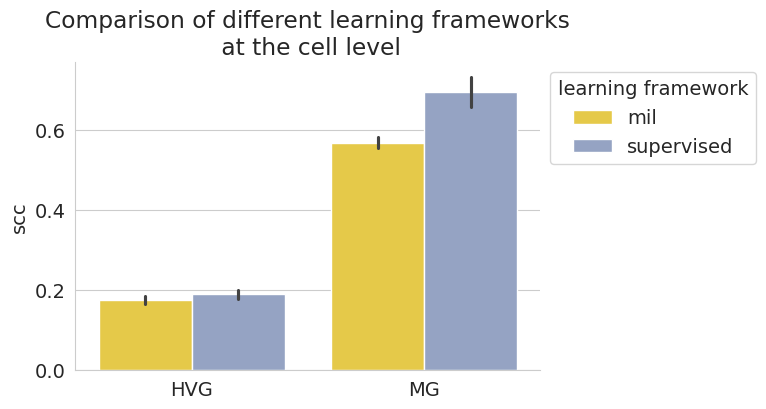

In [15]:
df_plot = metrics[
    (metrics["scenario"] == "cell")
    & (metrics["task type"] == "regression")
    & (metrics["embedding tag"] == "SSL embedding")
    & (metrics["infer mode"] == "instance")
    & (metrics["scale"] != "slide_scaling")
].copy()
for score in ["pcc", "scc"]:
    df_plot_ = select_best_lr_model(
        df_plot, columns=["learning framework", "lr"], metric=score, gene_cat="MG"
    )
    plot_metrics_simulation(
        df_plot_,
        x="genes",
        y=score,
        title="Comparison of different learning frameworks\n at the cell level",
        save_path=SAVE_PATH / f"comparison_learning_framework_test_cell_{score}.png",
        hue="learning framework",
    )